In [168]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle
import pandas as pd
from matplotlib.patches import Arc

resol = 300
pi = np.pi
version_table()

#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif"
#})

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Numerical scheme </h1>

In [2]:
def update_state(psi, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, t, dt):

    n_modes = len(k_tab_individual)

    #recovering qubit's and mirror parameters
    omega_A = qubit_A['omega']
    gamma_A = qubit_A['gamma']
    x_A = qubit_A['x']

    omega_B = qubit_B['omega']
    gamma_B = qubit_B['gamma']
    x_B = qubit_B['x']

    omega_M = mirror['omega']
    gamma_M = mirror['gamma']

    #10 one-excitation state
    psi_10 = psi[:2*n_modes + 2]
    q_10g = psi_10[:2*n_modes]
    q_20g = psi_10[-2]
    q_10e = psi_10[-1]
    #01 one-excitation state 
    psi_01 = psi[2*n_modes + 2: 4*n_modes+4]
    q_01g = psi_01[:2*n_modes]
    q_02g = psi_01[-2]
    q_01e = psi_01[-1]

    #prepare the matrix multiplications
    delta_A_matrix = np.concatenate((np.ones(n_modes),np.zeros(n_modes)))
    delta_B_matrix = np.concatenate((np.zeros(n_modes),np.ones(n_modes)))
    
    coupling_matrix_A = delta_A_matrix * 1j*np.sqrt(gamma_A/L) * np.exp(-1j*(k_tab-omega_A)*t + 1j*k_tab*x_A)
    coupling_matrix_B = delta_B_matrix * 1j*np.sqrt(gamma_B/L) * np.exp(-1j*(k_tab-omega_B)*t + 1j*k_tab*x_B)
    coupling_matrix_M = 1j*np.sqrt(gamma_M/(2*L)) * np.exp(-1j*(k_tab-omega_M)*t)

    #propagate the one-excitation states
    q_10g_new = np.conjugate(coupling_matrix_M) * q_10e + np.conjugate(coupling_matrix_A) * q_20g
    q_20g_new = coupling_matrix_A @ q_10g
    q_10e_new = coupling_matrix_M @ q_10g
    psi_10_new = np.concatenate((q_10g_new, np.array([q_20g_new]),np.array([q_10e_new])))

    q_01g_new = np.conjugate(coupling_matrix_M) * q_01e + np.conjugate(coupling_matrix_B) * q_02g
    q_02g_new = coupling_matrix_B @ q_01g
    q_01e_new = coupling_matrix_M @ q_01g
    psi_01_new = np.concatenate((q_01g_new, np.array([q_02g_new]),np.array([q_01e_new])))


    psi_update = np.concatenate((psi_10_new, psi_01_new))
    
    return -1j*dt*psi_update
    

In [3]:
def RG_scheme(psi_init, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, T, dt, progress_bar=True):

    nb_pts_time = int(T / dt)
    n_modes = len(k_tab_individual)
    dimension = (2*n_modes + 2) + (2*n_modes + 2)

    print("Subspace dimensionality: ", dimension)
    psi_list = np.zeros((nb_pts_time, dimension), dtype=complex)
    # Set the initial conditions
    psi_list[0] = psi_init

    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        
        psi_current = psi_list[i-1]

        psi_new_1 = update_state(psi_current, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, t, dt)
        psi_new_2 = update_state(psi_current + psi_new_1/2, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, t + dt/2, dt)
        psi_new_3 = update_state(psi_current + psi_new_2/2, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, t + dt/2, dt)
        psi_new_4 = update_state(psi_current + psi_new_3, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, t, dt)
        
        psi_new = psi_current + (psi_new_1 + 2*psi_new_2 + 2*psi_new_3 + psi_new_4) / 6

        psi_list[i] = psi_new

    return psi_list
    

<h1> Simulator </h1>

In [128]:
def bk_simulator(qubit_A, qubit_B, mirror, omega_min, omega_max, L, T, dt, print_nb_modes = False, progress_bar=True):

    #quantization of the modes
    k_tab_individual = np.array([2*pi*n/L for n in range(1000000) if (2*pi*n/L >= omega_min and 2*pi*n/L <= omega_max)])
    k_tab = np.concatenate((k_tab_individual, k_tab_individual))
    n_modes = len(k_tab_individual)

    if print_nb_modes:
        print("Number of modes: ", n_modes)
    
    #initialize the system
    #10 one-excitation state
    q_10g_init = np.zeros(2*n_modes)
    q_20g_init = 1/np.sqrt(2)
    q_10e_init = 0
    psi_10_init = np.concatenate((q_10g_init, np.array([q_20g_init]),np.array([q_10e_init])))
    #01 one-excitation state 
    q_01g_init = np.zeros(2*n_modes)
    q_02g_init = 1/np.sqrt(2)
    q_01e_init = 0
    psi_01_init = np.concatenate((q_01g_init, np.array([q_02g_init]),np.array([q_01e_init])))

    psi_init = np.concatenate((psi_10_init, psi_01_init))

    #run the evolution
    print("Evolving the state ...")
    psi_list = RG_scheme(psi_init, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, T, dt, progress_bar=True)

    return k_tab_individual, k_tab, psi_list
    

<h1> First test </h1>

In [192]:
L = 50*pi
T = L/2
dt = 0.01

#frequency cutoff
omega_min = 0
omega_max = 20


#mirror
omega_M = 10
gamma_M = 1
mirror = {'omega': omega_M, 'gamma': gamma_M}

#renormalized mirror frequency and mirror decay rate
prefactor_M = 1/(1+gamma_M/(2*pi)*(1/(omega_min - omega_M) - 1/(omega_max - omega_M)))
omega_M_phys = omega_M - gamma_M / (2*pi) * np.log((omega_max-omega_M)/(omega_M - omega_min)) * prefactor_M
gamma_M_phys = gamma_M * prefactor_M


#qubit A
omega_A = omega_M_phys - gamma_M_phys/2 - 0.017
gamma_A = 0.1
x_A = -L/4
qubit_A = {'omega': omega_A, 'gamma': gamma_A, 'x': x_A}

#qubit B
omega_B = omega_M_phys - gamma_M_phys/2 - 0.017
gamma_B = 0.1
x_B = -L/4
qubit_B = {'omega': omega_B, 'gamma': gamma_B, 'x': x_B}


k_tab_individual, k_tab, psi_list = bk_simulator(qubit_A, qubit_B, mirror, omega_min, omega_max, L, T, dt, print_nb_modes = True, progress_bar=True)

Number of modes:  501
Evolving the state ...
Subspace dimensionality:  2008


  0%|          | 0/7852 [00:00<?, ?it/s]

Store the coef 

In [193]:
n_modes = len(k_tab_individual)
nb_pts_time = int(T/dt)
time_list = np.linspace(0,T,nb_pts_time)

q_10g_list = np.zeros((nb_pts_time, 2 * n_modes), dtype=complex)
q_20g_list = np.zeros((nb_pts_time,), dtype=complex)
q_10e_list = np.zeros((nb_pts_time,), dtype=complex)

q_01g_list = np.zeros((nb_pts_time, 2 * n_modes), dtype=complex)
q_02g_list = np.zeros((nb_pts_time,), dtype=complex)
q_01e_list = np.zeros((nb_pts_time,), dtype=complex)


for i in tqdm(range(nb_pts_time)):
    psi = psi_list[i]

    #10 one-excitation state
    psi_10 = psi[:2*n_modes + 2]
    q_10g_list[i] = psi_10[:2*n_modes]
    q_20g_list[i] = psi_10[-2]
    q_10e_list[i] = psi_10[-1]
    #01 one-excitation state 
    psi_01 = psi[2*n_modes + 2: 4*n_modes+4]
    q_01g_list[i] = psi_01[:2*n_modes]
    q_02g_list[i] = psi_01[-2]
    q_01e_list[i] = psi_01[-1]

  0%|          | 0/7853 [00:00<?, ?it/s]

<h1> Probabilites PA and PB </h1>

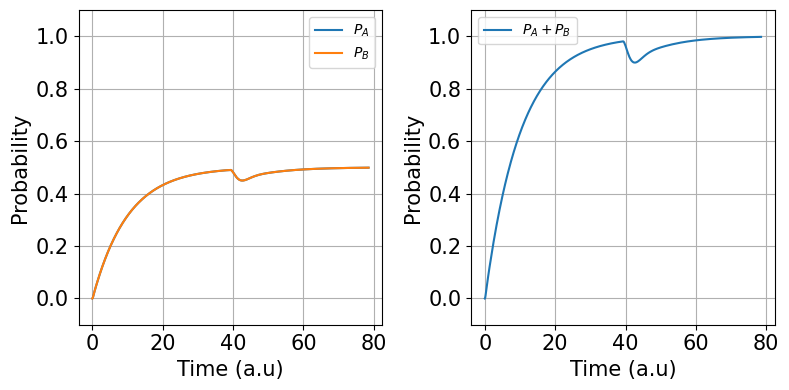

In [194]:
P_A_list = np.sum(np.abs(q_01g_list[:,:n_modes])**2, axis=1) + np.sum(np.abs(q_10g_list[:,:n_modes])**2, axis=1)
P_B_list = np.sum(np.abs(q_01g_list[:,n_modes:])**2, axis=1) + np.sum(np.abs(q_10g_list[:,n_modes:])**2, axis=1)

fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].plot(time_list, P_A_list, label=r'$P_A$')
ax[0].plot(time_list, P_B_list, label=r'$P_B$')


ax[1].plot(time_list, P_A_list + P_B_list, label=r'$P_A + P_B$')



#font size
for i in range(2):
    for item in [ax[i].xaxis.label, ax[i].yaxis.label]:
        item.set_fontsize(15)

    for item in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        item.set_fontsize(15)
    
    ax[i].set_xlabel('Time (a.u)')
    ax[i].set_ylabel('Probability')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].grid()
    ax[i].set_axisbelow(True)  
    ax[i].legend(prop={'size': 10})

plt.tight_layout()
plt.show()

In [195]:
p_10_A = np.sum(np.abs(q_10g_list[-1,:n_modes])**2)
p_10_B = np.sum(np.abs(q_10g_list[-1,n_modes:])**2)

p_01_A = np.sum(np.abs(q_01g_list[-1,:n_modes])**2)
p_01_B = np.sum(np.abs(q_01g_list[-1,n_modes:])**2)

print(p_01_A)
print(p_01_B)
print('----------------')
print(p_10_A)
print(p_10_B)

0.23643167787713049
0.26233698747152084
----------------
0.2623369874715209
0.23643167787713049


<h1> Check fidelity after collapsing </h1>

I assume that the photodetector is parameterized to only detect the qubit's frequencies 

In [196]:
index_qubit_freq = np.argmin(np.abs(k_tab_individual - omega_A))
coef_1 = q_01g_list[-1,index_qubit_freq]
coef_2 = q_10g_list[-1,index_qubit_freq]
norm = np.sqrt(np.abs(coef_1)**2 + np.abs(coef_2)**2)

c_1 = coef_1 / norm
c_2 = coef_2 / norm

concurrence =2* np.abs(c_1*c_2)


print(f"Probability to measure |01> = {np.abs(coef_1/norm)**2:.3f}")
print(f"Probability to measure |10> = {np.abs(coef_2/norm)**2:.3f}")

print("---------------")
print(f"Concurrence: {concurrence:.3f}")

Probability to measure |01> = 0.406
Probability to measure |10> = 0.594
---------------
Concurrence: 0.982


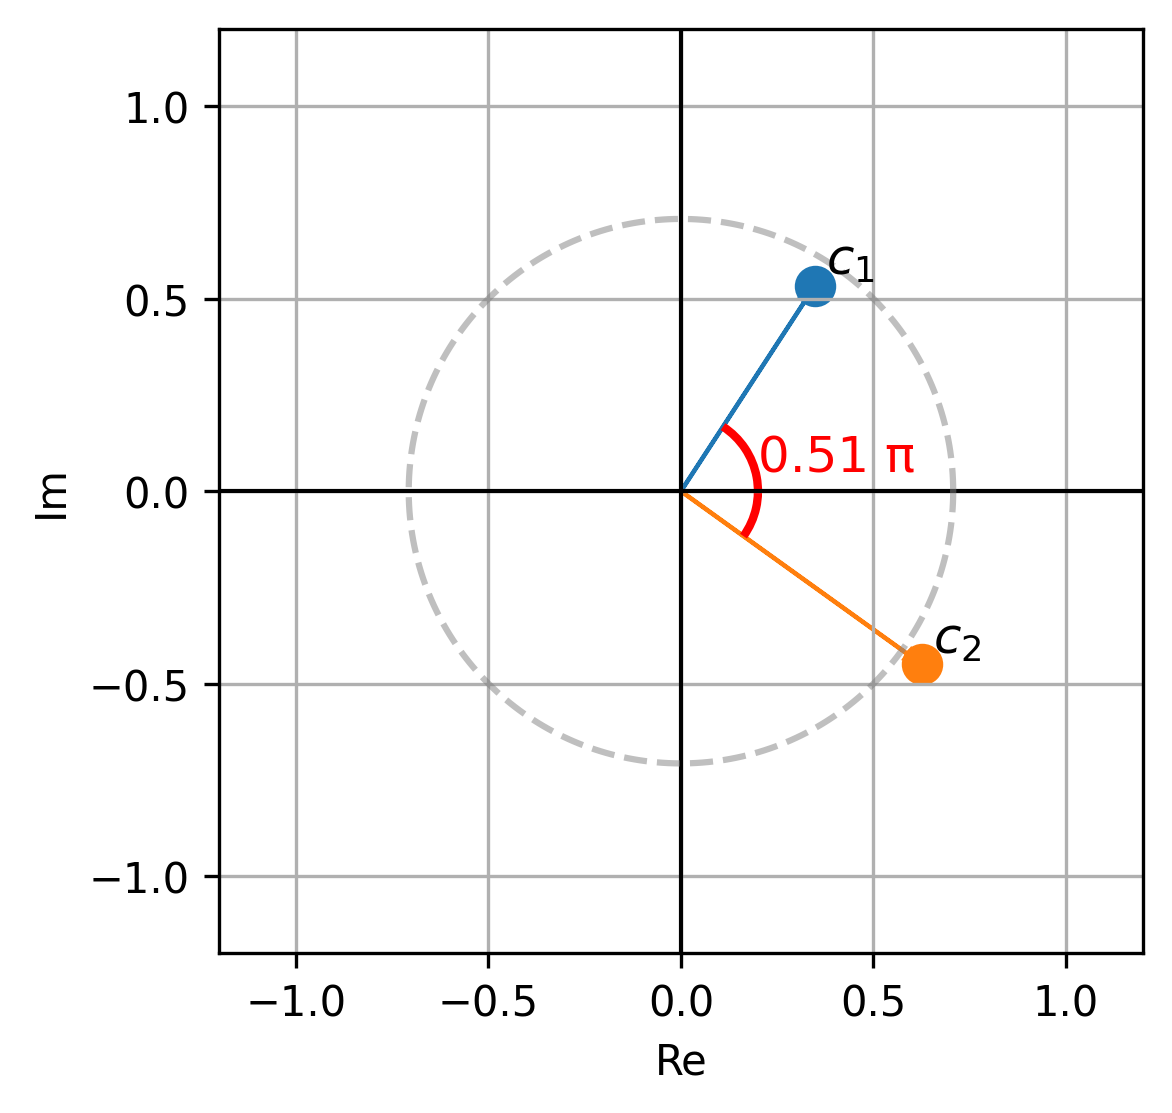

In [197]:
fig, ax = plt.subplots(figsize=(4,4), dpi=resol)

# Plot points
ax.scatter(c_1.real, c_1.imag, color='C0', s=80)
ax.scatter(c_2.real, c_2.imag, color='C1', s=80)

# Draw arrows from origin
ax.arrow(0, 0, c_1.real, c_1.imag,
         head_width=0.03, color='C0', length_includes_head=True)
ax.arrow(0, 0, c_2.real, c_2.imag,
         head_width=0.03, color='C1', length_includes_head=True)

# Annotate points
ax.text(c_1.real + 0.03, c_1.imag + 0.03, r'$c_1$', fontsize=12)
ax.text(c_2.real + 0.03, c_2.imag + 0.03, r'$c_2$', fontsize=12)

# Axes through origin
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

# Circle indicating 1/sqrt(2) modulus
theta = np.linspace(0, 2*np.pi, 300)
ax.plot(1/np.sqrt(2)*np.cos(theta), 1/np.sqrt(2)*np.sin(theta), 
        linestyle='--', color='gray', alpha=0.5)

# --- Add relative phase marker ---
# Compute angles of c1 and c2 in radians
angle1 = np.angle(c_1)  # radians
angle2 = np.angle(c_2)

# Compute relative phase in [0, 2*pi)
relative_phase = (angle1 - angle2) % (2*np.pi)

# Draw an arc from c1 to c2 in radians
arc_radius = 0.2
arc = Arc((0,0), 2*arc_radius, 2*arc_radius, angle=0,
          theta1=np.degrees(angle2), theta2=np.degrees(angle1), color='red', lw=2)
ax.add_patch(arc)

# Annotate the relative phase in units of pi
ax.text(arc_radius, 0.05, f'{relative_phase/np.pi:.2f} π', color='red', fontsize=12)

# Final plot settings
ax.set_aspect('equal')
ax.grid(True)
ax.set_xlabel("Re")
ax.set_ylabel("Im")
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)

plt.show()
